In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim

from torchessian import gauss_quadrature, F
from torchvision.models.resnet import conv3x3, resnet18, ResNet

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

m = 100
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train(net, optimizer, criterion, L, W):
    global trainloader
    for epoch in range(15):  # loop over the dataset multiple times    

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d] loss: %.3f' %
              (epoch + 1, running_loss / i))

        running_loss = 0.0

        l, w = gauss_quadrature(net, criterion, (inputs, labels), m, buffer=m)
        L.append(l)
        W.append(w)


def test(net):
    global testloader
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [4]:
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(512, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
L, W = [], []
train(net, optimizer, criterion, L, W)
test(net)

[1] loss: 1.429
[2] loss: 0.834
[3] loss: 0.642
[4] loss: 0.509
[5] loss: 0.396
[6] loss: 0.301
[7] loss: 0.216
[8] loss: 0.144
[9] loss: 0.094
[10] loss: 0.060
[11] loss: 0.039
[12] loss: 0.026
[13] loss: 0.020
[14] loss: 0.015
[15] loss: 0.012
Accuracy of the network on the 10000 test images: 75 %


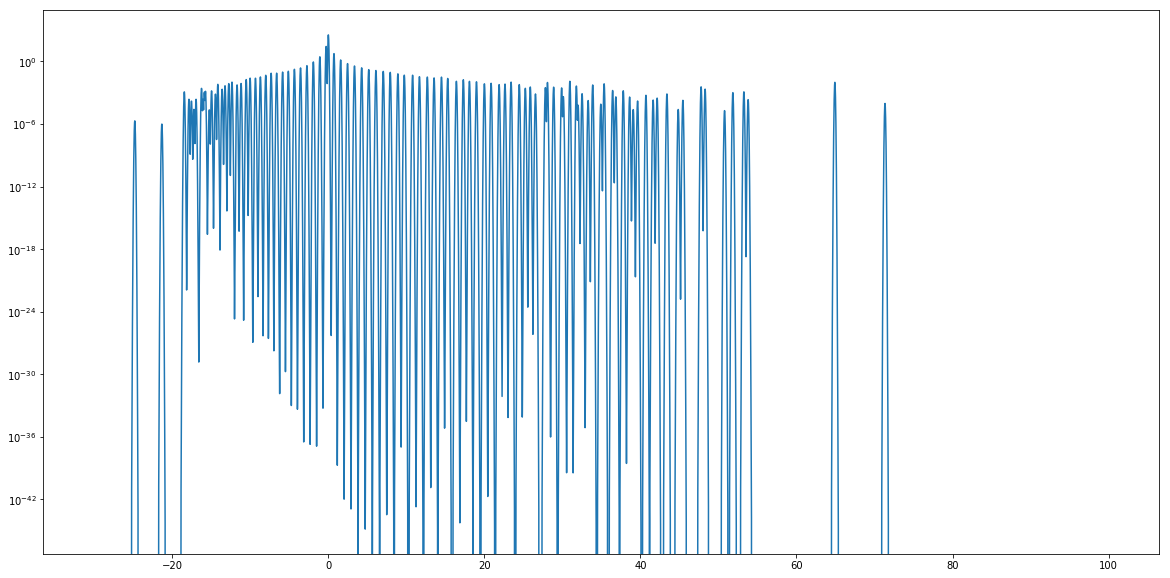

In [29]:
support = torch.linspace(-30, 100, 10000)
density = F(support, L[0], W[0], m)
plt.figure(figsize=(20,10))
plt.plot(support.numpy(), density.numpy())
plt.yscale('log')
plt.show()

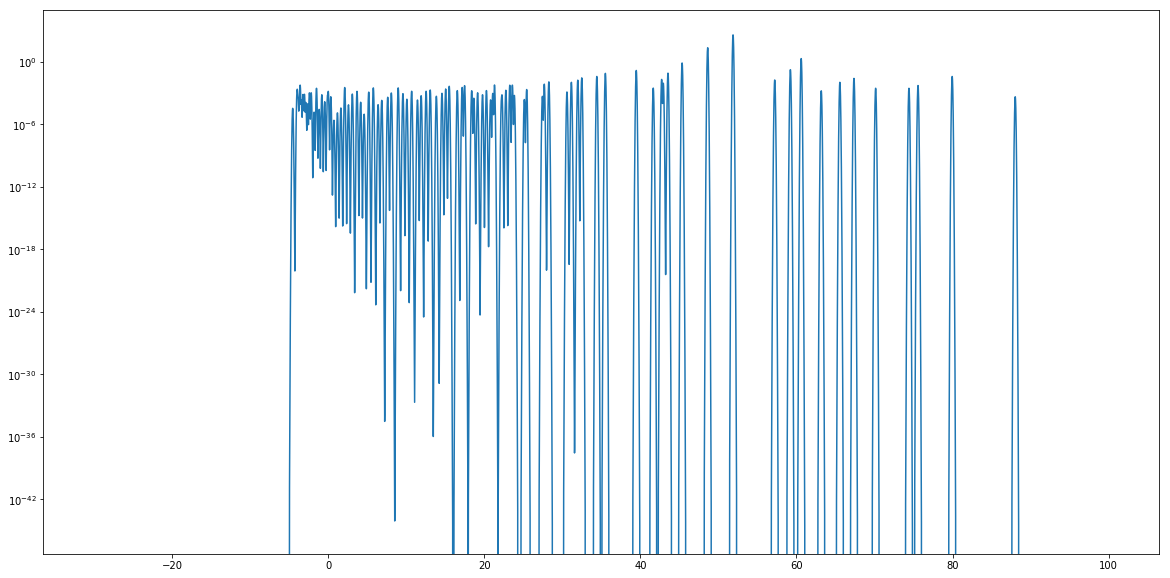

In [30]:
support = torch.linspace(-30, 100, 10000)
density = F(support, L[-1], W[-1], m)
plt.figure(figsize=(20,10))
plt.plot(support.numpy(), density.numpy())
plt.yscale('log')
plt.show()

In [8]:
class BasicBlockNoBN(torch.nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlockNoBN, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [9]:
net = ResNet(BasicBlockNoBN, [2, 2, 2, 2])
net.fc = torch.nn.Linear(512, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlockNoBN(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2):

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
L_no_bn, W_no_bn = [], []
train(net, optimizer, criterion, L_no_bn, W_no_bn)
test(net)

[1] loss: 1.736
[2] loss: 1.353
[3] loss: 1.194
[4] loss: 1.101
[5] loss: 1.025
[6] loss: 0.956
[7] loss: 0.911
[8] loss: 0.863
[9] loss: 0.814
[10] loss: 0.778
[11] loss: 0.738
[12] loss: 0.718
[13] loss: 0.671
[14] loss: 0.637
[15] loss: 0.596
Accuracy of the network on the 10000 test images: 69 %


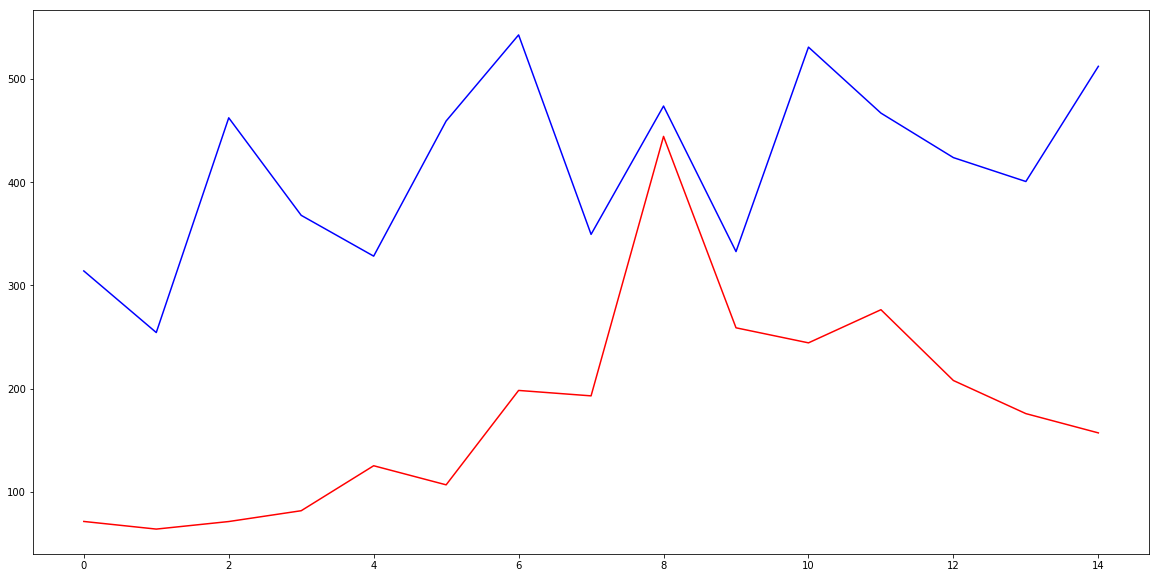

In [26]:
v_bn = []
v_no_bn = []

for i in range(15):
    v_bn.append(L[i].max().item())
    v_no_bn.append(L_no_bn[i].max().item())

plt.figure(figsize=(20,10))
plt.plot(v_bn, color='r')
plt.plot(v_no_bn, color='b')
plt.show()